# Monowai CC

General tools

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import read_inventory
import os
import ccf

In [89]:
%matplotlib notebook

In [23]:
ccf.clients.set(sds_root='/vardim/home/smets/Hydro')

In [3]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_max_abs_lag = 3600. * 3.5
title_prefix = 'Monowai Volcanic Centre'

# set output destination
dest = '/ribarsko/data/smets/MVC.CC.RAW'

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 4. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20}),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 4., 'freqmax': 10. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('decimate', { 'factor': 5 }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
    ],
}

In [4]:
inv = read_inventory('/vardim/home/smets/Research/hydro/Monowai/Monowai_EDH_BHZ.xml')
pairs = [
    'IM.H10N1..EDH-IU.RAR.00.BHZ',
    'IM.H10N2..EDH-IU.RAR.00.BHZ',
    'IM.H10N3..EDH-IU.RAR.00.BHZ',
]
times = pd.date_range('2006-01-01', '2018-01-01', freq='1D')

### single period

In [5]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)

In [6]:
pair = pairs[0]
time = times[0]

ncfile = os.path.join(dest,pair,filename(pair, time))

In [7]:
ds = ccf.init_dataset(
    pair=pair, 
    starttime = time, 
    endtime = time + pd.offsets.DateOffset(1), 
    preprocess = preprocess, 
    sampling_rate = sampling_rate, 
    window_length = window_length, 
    window_overlap = window_overlap, 
    clip_max_abs_lag = clip_max_abs_lag, 
    title_prefix = title_prefix
)

In [8]:
ds

<xarray.Dataset>
Dimensions:     (lag: 1260001, time: 8)
Coordinates:
  * lag         (lag) float64 -1.26e+04 -1.26e+04 ... 1.26e+04 1.26e+04
    pair        <U27 'IM.H10N1..EDH-IU.RAR.00.BHZ'
  * time        (time) datetime64[ns] 2006-01-01 ... 2006-01-01T21:00:00
Data variables:
    stats       int8 1
    operations  int8 1
    preprocess  bool True
    status      (time) int8 0 0 0 0 0 0 0 0
    cc          (time, lag) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        Monowai Volcanic Centre Cross-correlations - January 2006
    history:      Created @ 2019-12-19T14:11:07.511393Z
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   n/a
    comment:      n/a

### Test missing data

In [27]:
st = ccf.clients.get_preprocessed_pair_stream(
    pair = pairs[0],
    time = pd.to_datetime('2006-05-23T00:00:00'),
    operations = preprocess,
    duration = 86400,
    buffer = 86400/2,
    inventory = inv,
    operations_from_json = False,
    verbose=True,
    debug=True
)

Get waveforms for  IM H10N1  EDH 2006-05-22T00:00:00.000000Z 2006-05-24T00:00:00.000000Z
Get Waveform data for 2006-05-22T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 14399991, max gaps = 75000.
No waveform data found for day. Try IRIS.
No waveform data found for day. Try NMS_Client
Samples in day = 21600000, samples in stream = 14402501, max gaps = 75000.
Get Waveform data for 2006-05-23T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600002, max gaps = 75000.
Waveform data for 2006-05-23T00:00:00.000000Z loaded from archive.
Get Waveform data for 2006-05-24T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600002, max gaps = 75000.
Waveform data for 2006-05-24T00:00:00.000000Z loaded from archive.
16 Trace(s) in Stream:
IM.H10N1..EDH | 2006-05-23T00:00:00.000000Z - 2006-05-23T00:00:00.136000Z | 250.0 Hz, 35 samples
IM.H10N1..EDH | 2006-05-23T00:00:00.000000Z - 2006-05-23T00:00:00.856000Z | 250.0 Hz, 215 samples
IM.H10N1..EDH | 2

In [25]:
st

1 Trace(s) in Stream:
IU.RAR.00.BHZ | 2006-05-22T11:59:59.985600Z - 2006-05-23T11:59:59.985600Z | 50.0 Hz, 4320001 samples

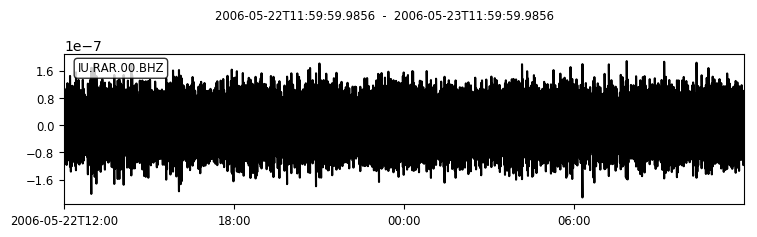

IndexError: list index out of range

In [26]:
%matplotlib inline
st[0].plot()
st[1].plot()

### Cross-correlate one month of data

In [83]:
ccf.cc_dataset(ds,inventory=inv)

IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T00:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T03:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T06:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T09:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T12:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T15:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T18:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.00.BHZ 2006-01-01T21:00:00. Waveforms. CC. Done.


In [ ]:
# ccf.write_dataset(ds,ncfile)

In [93]:
ds

<xarray.Dataset>
Dimensions:     (lag: 1260001, time: 8)
Coordinates:
  * lag         (lag) float64 -1.26e+04 -1.26e+04 ... 1.26e+04 1.26e+04
    pair        <U27 'IM.H10N1..EDH-IU.RAR.00.BHZ'
  * time        (time) datetime64[ns] 2006-01-01 ... 2006-01-01T21:00:00
Data variables:
    stats       int8 1
    operations  int8 1
    preprocess  bool True
    status      (time) int8 1 1 1 1 1 1 1 1
    cc          (time, lag) float32 -4.0585815e-06 ... 0.00081659935
Attributes:
    title:        Monowai Volcanic Centre Cross-correlations - January 2006
    history:      Created @ 2019-12-19T13:19:43.449568Z
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   n/a
    comment:      n/a

<IPython.core.display.Javascript object>


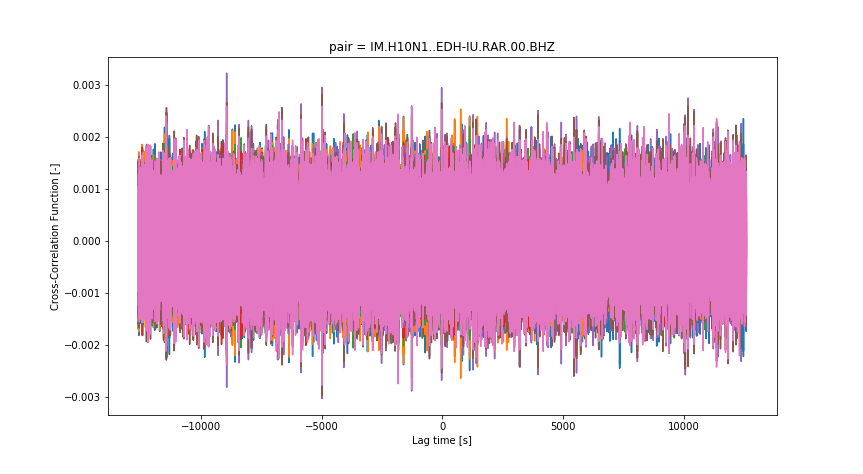

In [96]:
plt.figure(figsize=[9,4])
ds.cc.loc[{'time':ds.time[:-1]}].plot.line(x='lag',add_legend=False)

### A whole period

In [ ]:
for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = os.path.join(dest,pair,filename(pair, time))
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if np.all(ds.status.values == 1):
                ds.close()
                continue
        else:
            ds = ccf.init_dataset(
                pair=pair, 
                starttime = time, 
                endtime = time + pd.offsets.DateOffset(1), 
                preprocess = preprocess, 
                sampling_rate = sampling_rate, 
                window_length = window_length, 
                window_overlap = window_overlap, 
                clip_max_abs_lag = clip_max_abs_lag, 
                title_prefix = title_prefix
            )
        try:
            ccf.cc_dataset(ds,inventory=inv,retry_missing=True)
        except KeyboardInterrupt:
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep.')
            print('Error:')
            print(e)
        ccf.write_dataset(ds,ncfile)